In [1]:
import pandas as pd

## Read human genome

In [2]:
human_genome = pd.read_csv("human_genome.tsv", sep="\t", header=None)

## Get gene symbols to human genome index dataframe (is in nested list semicolon, comma separated)

In [3]:
human_genome["human_genome_index"] = human_genome.index

In [4]:
sem_split = human_genome[3].str.split("; ")

In [5]:
comma_split = sem_split.map(lambda n: n[0]).str.split(",")

In [6]:
exploded_gene_symbols = comma_split.explode().str.strip().to_frame()

In [7]:
exploded_gene_symbols = exploded_gene_symbols.rename(columns={3:"symbol"})

In [8]:
exploded_gene_symbols["human_genome_index"] = exploded_gene_symbols.index

In [9]:
exploded_gene_symbols = exploded_gene_symbols.reset_index(drop=True)

## Read copy numbers

In [10]:
copy_numbers = pd.read_csv("WES_pureCN_CNV_genes_20220623.csv")

## Merge copy numbers with gene index to edge index

In [247]:
human_genome_index_merged_copy_numbers = pd.merge(exploded_gene_symbols, copy_numbers, on=["symbol","symbol"], how="right")

In [248]:
human_genome_index_merged_copy_numbers["index"] = human_genome_index_merged_copy_numbers.index

In [253]:
human_genome_index_merged_copy_numbers

,symbol,human_genome_index,model_name,model_id,gene_id,chr_name,chr_start,chr_end,total_copy_number,minor_copy_number,...,gene_mean,num_targets,focal,breakpoints,num_snps,gatk_mean_log2_copy_ratio,comment,source,data_type,index
0,ABCB1,8707,MEC-1,SIDM00001,SIDG00064,chr7,87503966,87600461,3.0,1.0,...,0.414125,28.0,False,0.0,1124.0,0.574127,POOR GOF (70.4%),Sanger,WES,0
1,ABL1,10859,MEC-1,SIDM00001,SIDG00150,chr9,130714099,130885948,3.0,1.0,...,0.472693,12.0,False,0.0,977.0,0.585569,POOR GOF (70.4%),Sanger,WES,1
2,BRD3,10921,MEC-1,SIDM00001,SIDG02504,chr9,134033313,134053689,3.0,1.0,...,0.705704,11.0,False,0.0,977.0,0.585569,POOR GOF (70.4%),Sanger,WES,2
3,CARD11,8252,MEC-1,SIDM00001,SIDG03455,chr7,2906361,2958783,3.0,1.0,...,0.696245,23.0,False,0.0,1124.0,0.574127,POOR GOF (70.4%),Sanger,WES,3
4,CDK6,8741,MEC-1,SIDM00001,SIDG04156,chr7,92614869,92833599,3.0,1.0,...,0.750720,7.0,False,0.0,1124.0,0.574127,POOR GOF (70.4%),Sanger,WES,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1142907,JAK3,19738,EA-hy926,SIDM01986,SIDG13376,chr19,17826466,17844694,4.0,1.0,...,0.172797,20.0,False,0.0,2308.0,0.209350,POOR GOF (75%),Sanger,WES,1142907
1142908,KAT6A,9602,EA-hy926,SIDM01986,SIDG13444,chr8,41931928,42049234,2.0,1.0,...,-0.783567,19.0,False,0.0,39.0,-0.812879,POOR GOF (75%),Sanger,WES,1142908
1142909,KAT6B,11438,EA-hy926,SIDM01986,SIDG13445,chr10,74842581,75031323,3.0,1.0,...,-0.176008,18.0,False,0.0,2542.0,-0.144490,POOR GOF (75%),Sanger,WES,1142909
1142910,KNL1,15959,EA-hy926,SIDM01986,SIDG13936,chr15,40602655,40662465,4.0,1.0,...,-0.109242,24.0,False,0.0,376.0,0.083666,POOR GOF (75%),Sanger,WES,1142910


## Generate nodes features for gene nodes

In [14]:
human_genome[0] = human_genome[0].astype("category")
human_genome[1] = human_genome[1].astype("category")
human_genome[2] = human_genome[2].astype("category")
cat_columns = human_genome.select_dtypes(['category']).columns
human_genome[cat_columns] = human_genome[cat_columns].apply(lambda x: x.cat.codes)

In [16]:
def z_scale(df_z_scaled, columns):
    for column in columns:
        df_z_scaled[column] = (df_z_scaled[column] - df_z_scaled[column].mean()) / df_z_scaled[column].std()   
    return df_z_scaled
z_scale(human_genome, [0,1,2])

,0,1,2,3,human_genome_index
0,-1.435618,0.983335,-0.020788,"MIR6859-1, hsa-mir-6859-1; microRNA 6859-1",0
1,-1.656741,0.983335,-0.136196,"MIR1302-2, MIRN1302-2, hsa-mir-1302-2; microRN...",1
2,1.243678,-0.403875,-0.104359,OR4F5; olfactory receptor family 4 subfamily F...,2
3,-1.447965,0.983335,-0.012534,"MIR6859-2, hsa-mir-6859-2; microRNA 6859-2",3
4,-1.250834,-0.403875,0.049518,uncharacterized LOC112268260,4
...,...,...,...,...,...
24684,-0.824442,-0.403875,1.582393,G antigen 7-like,24684
24685,-0.757796,-0.403875,0.831284,putative TAF11-like protein ENSP05220103537,24685
24686,-0.742643,-0.403875,1.158936,Uncharacterized LOC132932482,24686
24687,-0.741521,-0.403875,-1.188131,POC1B-DUSP6; POC1B-DUSP6 readthrough,24687


In [237]:
gene_features = human_genome.iloc[:, :3].values
gene_features

array([[-1.43561788,  0.98333456, -0.02078813],
       [-1.6567412 ,  0.98333456, -0.13619594],
       [ 1.24367835, -0.40387457, -0.1043593 ],
       ...,
       [-0.74264322, -0.40387457,  1.15893607],
       [-0.74152077, -0.40387457, -1.18813143],
       [-0.74138046, -0.40387457,  1.4434023 ]])

## Generate Model nodes

In [38]:
targets = pd.read_csv("target.csv",sep=";")

In [202]:
models = pd.read_csv("model_list_20240110.csv")

In [210]:
def remove_uninformative_columns(columns):
    ## removes columns where we have no duplicates (i.e., columns with all different categorical values like ids)
    filtered_columns = []
    for column in columns:
        if models.duplicated(subset=column).sum() > 0:
            filtered_columns.append(column)
    return filtered_columns

In [211]:
from matplotlib import pyplot as plt
columns_with_most_val_filled = models.columns[models.isnull().sum(axis=0)/ models.shape[0] <= 0.1]
filtered_columns = remove_uninformative_columns(columns_with_most_val_filled)

In [212]:
filtered_columns.append("model_id")

In [213]:
models = models[filtered_columns].fillna("Unkown")

In [214]:
def categorize_columns(df, columns):
    for column in columns:
        df[column] = df[column].astype("category")
    cat_columns = df.select_dtypes(['category']).columns
    df[cat_columns] = df[cat_columns].apply(lambda x: x.cat.codes)
    return df

In [215]:
columns_besides_id = list(filter(lambda x: x != "model_id", filtered_columns))
models = categorize_columns(models, columns_besides_id)
z_scale(models, columns_besides_id)

,sample_id,patient_id,model_name,tissue,cancer_type,cancer_type_ncit_id,tissue_status,sample_site,cancer_type_detail,model_type,growth_properties,gender,ethnicity,smoking_status,sample_treatment,crispr_ko_data,model_id
0,1.122774,1.137185,0.876928,0.743954,1.102971,-0.581066,-1.615904,-0.605693,0.930356,-0.268525,-0.958391,1.993544,0.179845,0.252464,0.273661,-0.857184,SIDM01774
1,-0.654235,-0.637455,1.208447,0.082968,-0.913954,1.805786,0.510026,0.279862,1.231074,-0.268525,-0.958391,-1.142286,-1.907582,0.252464,0.592958,1.166070,SIDM00192
2,0.796733,0.852343,1.261555,-1.239003,-0.387800,-1.295692,0.510026,-1.595431,-0.225033,-0.268525,-0.958391,0.425629,0.179845,0.252464,0.592958,-0.857184,SIDM01447
3,0.624324,0.668695,-0.371903,0.413461,0.226047,0.062098,1.041509,0.175679,1.104456,-0.268525,-0.958391,0.425629,0.875654,0.252464,0.273661,1.166070,SIDM01554
4,1.074977,1.097832,0.207451,-0.412771,-1.615493,1.448473,0.510026,0.019404,-1.491213,-0.268525,0.550803,0.425629,0.179845,0.252464,0.273661,-0.857184,SIDM01689
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2150,1.687798,1.716239,0.664498,1.404939,0.138355,-1.109889,-1.615904,-1.426134,0.392229,-0.268525,-0.958391,0.425629,0.179845,0.252464,0.273661,-0.857184,SIDM02155
2151,1.739009,1.770583,1.686415,-0.578017,0.138355,1.119745,-1.615904,-0.540579,1.864164,-0.268525,-0.958391,-1.142286,0.179845,0.252464,0.273661,-0.857184,SIDM02157
2152,1.727059,1.757466,-1.009193,-0.412771,-1.001646,-1.195644,0.510026,-1.634499,-0.968914,-0.268525,-0.958391,0.425629,0.179845,0.252464,-3.557894,-0.857184,SIDM02159
2153,1.341273,1.345195,1.189135,-0.082278,0.050662,-0.352385,0.510026,-0.840105,-0.953087,-0.268525,-0.958391,1.993544,0.179845,0.252464,0.273661,1.166070,SIDM01339


In [153]:
pivot_targets.isnull().sum(axis = 0)[pivot_targets.isnull().sum(axis = 0) == 0]

DRUG_ID
1862    0
dtype: int64

In [216]:
models = models.rename(columns={"model_id":"SANGER_MODEL_ID"})

In [224]:
limited_drug_target = targets[targets["DRUG_ID"] == 1862]
limited_drug_target_filtered = limited_drug_target.loc[:, ["CELL_LINE_NAME", "SANGER_MODEL_ID", "MIN_CONC", "LN_IC50"]]
limited_drug_target_filtered = categorize_columns(limited_drug_target_filtered, ["CELL_LINE_NAME"])
z_scale(limited_drug_target_filtered, list(filter(lambda x: x not in["LN_IC50", "SANGER_MODEL_ID"], limited_drug_target_filtered)))

,CELL_LINE_NAME,SANGER_MODEL_ID,MIN_CONC,LN_IC50
174561,0.900416,SIDM01132,0.549643,-2.242366
174562,-1.632898,SIDM00848,0.549643,-1.531149
174563,-1.018328,SIDM00263,-1.817486,-1.779533
174564,-1.011182,SIDM00269,0.549643,-1.506878
174565,-0.982597,SIDM00203,0.549643,-1.253906
...,...,...,...,...
175525,1.289882,SIDM00214,0.549643,-1.756688
175526,1.304175,SIDM00194,0.549643,-0.712017
175527,1.307748,SIDM00193,-1.817486,-0.733869
175528,1.318467,SIDM00498,0.549643,-1.468859


In [225]:
model_drug_information = pd.merge(limited_drug_target_filtered, models, how="left", on="SANGER_MODEL_ID")

## Define Labels

In [232]:
node_labels = model_drug_information.pop("LN_IC50").values

In [236]:
model_feature_columns = list(filter(lambda x: x != "SANGER_MODEL_ID", model_drug_information.columns))
model_features = model_drug_information[model_feature_columns].values

In [254]:
human_genome_index_merged_copy_numbers = human_genome_index_merged_copy_numbers.rename(columns={"model_id": "SANGER_MODEL_ID"})

In [255]:
model_drug_information["model_idx"] = model_drug_information.index

In [257]:
model_gene_merge = pd.merge(human_genome_index_merged_copy_numbers, model_drug_information, on="SANGER_MODEL_ID", how="right")

In [269]:
model_drug_information[model_drug_information["model_idx"] == 0]

,CELL_LINE_NAME,SANGER_MODEL_ID,MIN_CONC,sample_id,patient_id,model_name,tissue,cancer_type,cancer_type_ncit_id,tissue_status,sample_site,cancer_type_detail,model_type,growth_properties,gender,ethnicity,smoking_status,sample_treatment,crispr_ko_data,model_idx
0,0.900416,SIDM01132,0.549643,-1.120252,-1.117189,0.867272,-1.239003,0.927586,-0.752576,0.510026,-1.452179,1.183592,-0.268525,-0.958391,0.425629,0.875654,0.252464,0.273661,-0.857184,0


In [275]:
model_to_edge_copy_number_edge_index = model_gene_merge.loc[:, ["model_idx", "human_genome_index"]].values

## Edge attributes for model_id -> gene_id (copy number edges)

In [24]:
reduced_model_gene_attributes = human_genome_index_merged_copy_numbers.loc[:, ['total_copy_number',
       'minor_copy_number', 'cn_category', 'seg_mean', 'gene_mean', 'num_targets', 'num_snps', 'gatk_mean_log2_copy_ratio']]

### Categorize

In [25]:
reduced_model_gene_attributes['cn_category'] = reduced_model_gene_attributes['cn_category'].astype("category")
reduced_model_gene_attributes_cat_columns = reduced_model_gene_attributes.select_dtypes(['category']).columns
reduced_model_gene_attributes[reduced_model_gene_attributes_cat_columns] = reduced_model_gene_attributes[reduced_model_gene_attributes_cat_columns].apply(lambda x: x.cat.codes)

In [27]:
z_scale(reduced_model_gene_attributes, reduced_model_gene_attributes.columns)
copy_number_edge_attributes = reduced_model_gene_attributes.fillna(0).values

,total_copy_number,minor_copy_number,cn_category,seg_mean,gene_mean,num_targets,num_snps,gatk_mean_log2_copy_ratio
0,-0.390072,0.100871,0.537622,0.020301,0.308448,-0.63001,1.501018,0.060987
1,-0.390072,0.100871,0.537622,0.154706,0.057532,-0.63001,-1.000464,0.043424
2,0.091222,0.100871,0.537622,-0.226539,-0.184511,-0.63001,-0.505500,-0.242489
3,0.572517,1.741925,-1.779717,0.350138,0.496381,-0.63001,1.356862,0.515339
4,0.572517,1.741925,0.537622,0.184721,0.333692,-0.63001,-0.961300,0.085520
...,...,...,...,...,...,...,...,...
1142907,NaN,NaN,-2.938386,NaN,NaN,NaN,NaN,-3.845421
1142908,NaN,NaN,-2.938386,NaN,NaN,NaN,NaN,-3.500768
1142909,NaN,NaN,0.537622,NaN,NaN,NaN,NaN,0.245607
1142910,NaN,NaN,-2.938386,NaN,NaN,NaN,NaN,-7.742590


## Read mutations

In [288]:
mutations = pd.read_csv("mutations_summary_20221018.csv")

In [289]:
mutations = mutations.loc[:, ["gene_symbol", "model_id", "protein_mutation", "rna_mutation", "cdna_mutation", "cancer_driver", "cancer_predisposition_variant", "effect", "vaf"]]

In [291]:
columns_besides_ids = list(filter(lambda x: x not in ["model_id", "gene_symbol"], mutations.columns))
mutations = categorize_columns(mutations, columns_besides_ids)

In [293]:
mutations = mutations.rename(columns={"gene_symbol":"symbol"})

In [294]:
##TODO merge with genes for gene nodes idx and with models model node idx
pd.merge(exploded_gene_symbols, mutations, on="symbol", how="right")

,symbol,human_genome_index,model_id,protein_mutation,rna_mutation,cdna_mutation,cancer_driver,cancer_predisposition_variant,effect,vaf
0,KRAS,1192,SIDM02080,4171,4498,1878,1,0,3,3195
1,KRAS,13631,SIDM02080,4171,4498,1878,1,0,3,3195
2,TP53,17711,SIDM02080,948,6978,5692,1,0,4,3195
3,SMAD4,19073,SIDM02080,18,1385,7155,1,0,0,3195
4,PREX2,9709,SIDM02080,1255,2399,1539,1,0,3,685
...,...,...,...,...,...,...,...,...,...,...
13441,VHL,3917,SIDM01335,2020,599,3808,1,0,3,3099
13442,RB1,14708,SIDM01444,6469,2139,1594,1,0,4,3081
13443,TP53,17711,SIDM01444,5936,5869,4075,1,0,3,2134
13444,TP53,17711,SIDM01444,356,7356,6203,1,0,3,1319


In [133]:
pivot_targets = pd.pivot_table(targets, values="LN_IC50", index=["SANGER_MODEL_ID"],
                       columns=['DRUG_ID'])

pd.merge(targets.loc[:, ["SANGER_MODEL_ID",'PUTATIVE_TARGET', 'PATHWAY_NAME', 'MIN_CONC', 'MAX_CONC']], pivot_targets, on=["SANGER_MODEL_ID","SANGER_MODEL_ID"])

,DATASET,NLME_RESULT_ID,NLME_CURVE_ID,COSMIC_ID,CELL_LINE_NAME,SANGER_MODEL_ID,TCGA_DESC,DRUG_ID,DRUG_NAME,PUTATIVE_TARGET,...,2175,2177,2359,2360,2361,2362,2438,2439,2498,2499
0,GDSC2,401,18945558,683667,PFSK-1,SIDM01132,MB,1003,Camptothecin,TOP1,...,NaN,2.366388,NaN,NaN,NaN,NaN,NaN,NaN,7.846626,10.613759
1,GDSC2,401,18945796,684052,A673,SIDM00848,UNCLASSIFIED,1003,Camptothecin,TOP1,...,NaN,1.723942,5.240599,4.432934,4.716167,4.285911,7.793623,9.156372,7.568813,7.063871
2,GDSC2,401,18946078,684057,ES5,SIDM00263,UNCLASSIFIED,1003,Camptothecin,TOP1,...,4.879849,1.901766,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,GDSC2,401,18946335,684059,ES7,SIDM00269,UNCLASSIFIED,1003,Camptothecin,TOP1,...,NaN,2.133421,4.578782,3.893851,3.137208,2.719145,8.871504,9.302207,6.655762,9.441838
4,GDSC2,401,18946617,684062,EW-11,SIDM00203,UNCLASSIFIED,1003,Camptothecin,TOP1,...,NaN,1.880307,5.137711,4.863771,5.007426,5.389040,10.462131,9.801610,8.228663,10.817398
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
242031,GDSC2,401,19187490,1659928,SNU-175,SIDM00216,COREAD,2499,N-acetyl cysteine,Metabolism,...,NaN,1.310061,5.423870,5.397164,5.401524,4.973343,9.264933,9.211173,7.445385,10.134495
242032,GDSC2,401,19187943,1660034,SNU-407,SIDM00214,COREAD,2499,N-acetyl cysteine,Metabolism,...,NaN,2.628609,5.042005,5.055076,4.918666,4.122141,11.121460,9.528520,8.344004,8.575555
242033,GDSC2,401,19188201,1660035,SNU-61,SIDM00194,COREAD,2499,N-acetyl cysteine,Metabolism,...,NaN,2.866949,6.130028,5.649833,4.392357,4.382946,10.879932,10.092187,7.743591,10.520666
242034,GDSC2,401,19188741,1674021,SNU-C5,SIDM00498,COREAD,2499,N-acetyl cysteine,Metabolism,...,NaN,2.653533,6.151265,6.022426,5.661197,4.820414,9.652950,10.181355,7.305220,10.701430


In [117]:
models["sample_treatment"]

0            Unknown
1                NaN
2                NaN
3            Unknown
4            Unknown
            ...     
2150         Unknown
2151         Unknown
2152    Chemotherapy
2153         Unknown
2154         Unknown
Name: sample_treatment, Length: 2155, dtype: object

In [116]:
models["cancer_type_ncit_id"].value_counts().index[0]

'C4349'

In [84]:
mutations = pd.read_csv("mutations_summary_20221018.csv")

In [14]:
import pandas as pd
rna_seq = pd.read_csv("rnaseq_tpm_20220624.csv",index_col=0, header = None)

/tmp/ipykernel_2196252/3286408976.py:2: DtypeWarning: Columns (2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262

In [27]:
rna_seq_t = rna_seq.transpose().iloc[1:, :]

In [32]:
rna_seq_t

,model_id,model_name,dataset_name,data_source,gene_id,SIDG00001,SIDG00002,SIDG00003,SIDG00004,SIDG00005,...,SIDG42469,SIDG42470,SIDG42471,SIDG42472,SIDG42473,SIDG42474,SIDG42475,SIDG42479,SIDG42480,SIDG42481
2,SIDM00001,MEC-1,Sanger & Broad Cell Lines RNASeq,Broad,NaN,0.53,2.43,0.03,0.33,0.0,...,2.86,0.0,9.09,28.1,0.0,11.75,14.21,8.32,6.03,2.06
3,SIDM00002,NBsusSR,Sanger & Broad Cell Lines RNASeq,Sanger,NaN,0.78,6.01,0.0,0.75,0.71,...,2.06,0.0,31.47,56.08,0.0,23.72,45.16,11.52,5.3,0.57
4,SIDM00003,M14,Sanger & Broad Cell Lines RNASeq,Sanger,NaN,0.49,11.54,0.0,29.14,0.83,...,13.27,0.31,29.87,179.63,0.0,25.23,44.7,7.59,5.89,1.94
5,SIDM00005,MDA-MB-134-VI,Sanger & Broad Cell Lines RNASeq,Broad,NaN,3.29,7.71,0.0,0.87,5.59,...,3.82,0.0,14.97,25.96,0.0,12.74,26.87,28.42,18.97,1.25
6,SIDM00006,MCC26,Sanger & Broad Cell Lines RNASeq,Sanger,NaN,0.56,7.53,0.04,86.17,1.04,...,16.66,0.0,27.87,525.84,0.0,12.91,32.47,10.91,4.79,0.41
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1428,SIDM02076,HCM-SANG-1322-C15,Sanger Organoid RNASeq,Sanger,NaN,0.0,0.08,0.42,0.0,0.48,...,0.0,0.0,2.52,76.28,0.0,4.12,NaN,0.37,5.36,1.03
1429,SIDM02077,HCM-SANG-1332-C18,Sanger Organoid RNASeq,Sanger,NaN,0.02,0.0,1.42,0.0,0.14,...,0.03,0.0,17.12,318.91,0.0,14.09,NaN,0.98,3.69,1.78
1430,SIDM02078,HCM-SANG-1095-C25,Sanger Organoid RNASeq,Sanger,NaN,0.0,0.0,1.91,0.09,0.42,...,0.0,0.0,5.69,194.7,0.0,11.05,NaN,1.31,5.69,1.99
1431,SIDM02079,HCM-SANG-1336-C15,Sanger Organoid RNASeq,Sanger,NaN,0.0,0.02,0.02,1.13,0.46,...,0.04,0.0,6.17,29.15,0.0,11.73,NaN,1.31,2.87,0.63


In [45]:
target = pd.read_csv("target.csv",sep=";")

In [55]:
target.duplicated(subset="SANGER_MODEL_ID")

0         False
1         False
2         False
3         False
4         False
          ...  
242031     True
242032     True
242033     True
242034     True
242035     True
Length: 242036, dtype: bool

In [66]:
target.loc[target["DRUG_ID"] ==1003, :]

,DATASET,NLME_RESULT_ID,NLME_CURVE_ID,COSMIC_ID,CELL_LINE_NAME,SANGER_MODEL_ID,TCGA_DESC,DRUG_ID,DRUG_NAME,PUTATIVE_TARGET,PATHWAY_NAME,COMPANY_ID,WEBRELEASE,MIN_CONC,MAX_CONC,LN_IC50,AUC,RMSE,Z_SCORE
0,GDSC2,401,18945558,683667,PFSK-1,SIDM01132,MB,1003,Camptothecin,TOP1,DNA replication,1046,Y,0.000100,0.1,-1.462148,0.930105,0.088999,0.432482
1,GDSC2,401,18945796,684052,A673,SIDM00848,UNCLASSIFIED,1003,Camptothecin,TOP1,DNA replication,1046,Y,0.000100,0.1,-4.869447,0.614932,0.111423,-1.420322
2,GDSC2,401,18946078,684057,ES5,SIDM00263,UNCLASSIFIED,1003,Camptothecin,TOP1,DNA replication,1046,Y,0.000100,0.1,-3.360684,0.790953,0.142754,-0.599894
3,GDSC2,401,18946335,684059,ES7,SIDM00269,UNCLASSIFIED,1003,Camptothecin,TOP1,DNA replication,1046,Y,0.000100,0.1,-5.045014,0.592624,0.135642,-1.515791
4,GDSC2,401,18946617,684062,EW-11,SIDM00203,UNCLASSIFIED,1003,Camptothecin,TOP1,DNA replication,1046,Y,0.000100,0.1,-3.741620,0.733992,0.128066,-0.807038
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
963,GDSC2,401,19187671,1660034,SNU-407,SIDM00214,COREAD,1003,Camptothecin,TOP1,DNA replication,1046,Y,0.000098,0.1,-1.611082,0.898907,0.079776,0.351495
964,GDSC2,401,19187944,1660035,SNU-61,SIDM00194,COREAD,1003,Camptothecin,TOP1,DNA replication,1046,Y,0.000100,0.1,1.350655,0.984590,0.047639,1.962014
965,GDSC2,401,19188202,1660036,SNU-81,SIDM00193,COREAD,1003,Camptothecin,TOP1,DNA replication,1046,Y,0.000098,0.1,0.075422,0.984215,0.048944,1.268574
966,GDSC2,401,19188460,1674021,SNU-C5,SIDM00498,COREAD,1003,Camptothecin,TOP1,DNA replication,1046,Y,0.000098,0.1,-2.420719,0.835807,0.080619,-0.088765


In [88]:
target.loc[target["SANGER_MODEL_ID"] =="SIDM00023", :]

,DATASET,NLME_RESULT_ID,NLME_CURVE_ID,COSMIC_ID,CELL_LINE_NAME,SANGER_MODEL_ID,TCGA_DESC,DRUG_ID,DRUG_NAME,PUTATIVE_TARGET,PATHWAY_NAME,COMPANY_ID,WEBRELEASE,MIN_CONC,MAX_CONC,LN_IC50,AUC,RMSE,Z_SCORE
648,GDSC2,401,19111420,946356,TE-12,SIDM00023,ESCA,1003,Camptothecin,TOP1,DNA replication,1046,Y,0.000100,0.1000,0.196652,0.947153,0.065203,1.334496
3860,GDSC2,401,19111421,946356,TE-12,SIDM00023,ESCA,1007,Docetaxel,Microtubule stabiliser,Mitosis,1046,Y,0.000013,0.0125,-4.497315,0.821634,0.069676,-0.089781
4769,GDSC2,401,19111422,946356,TE-12,SIDM00023,ESCA,1008,Methotrexate,Antimetabolite,DNA replication,1046,Y,0.001001,1.0000,3.534484,0.969402,0.057249,1.277224
5187,GDSC2,401,19111423,946356,TE-12,SIDM00023,ESCA,1009,Tretinoin,Retinoic acid,Other,1046,Y,0.010005,10.0000,6.126308,0.973836,0.053381,1.313027
5929,GDSC2,401,19111424,946356,TE-12,SIDM00023,ESCA,1010,Gefitinib,EGFR,EGFR signaling,1046,Y,0.002001,2.0000,0.705289,0.830640,0.092328,-2.014027
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
233521,GDSC2,401,19111672,946356,TE-12,SIDM00023,ESCA,2172,JQ1,"BRD2, BRD3, BRD4, BRDT",Chromatin other,1046,Y,0.010005,10.0000,2.901871,0.868092,0.068280,0.448795
234474,GDSC2,401,19111673,946356,TE-12,SIDM00023,ESCA,2173,PFI-1,BRD4,Chromatin other,1046,Y,0.010005,10.0000,6.067360,0.972985,0.036670,1.787430
234909,GDSC2,401,19111674,946356,TE-12,SIDM00023,ESCA,2174,IOX2,EGLN1,Other,1046,Y,0.000500,0.5000,3.403364,0.977455,0.038117,1.220332
235134,GDSC2,401,19111675,946356,TE-12,SIDM00023,ESCA,2175,CHIR-99021,"GSK3A, GSK3B",WNT signaling,1046,Y,0.010005,10.0000,6.464915,0.978254,0.037647,1.237660


In [68]:
pivot_targets = pd.pivot_table(target, values="LN_IC50", index=["SANGER_MODEL_ID"],
                       columns=['DRUG_ID'])

In [74]:
pivot_targets #enough drugs with high frequency (cut of 500?: drugs > 100)

DRUG_ID,1003,1004,1005,1006,1007,1008,1009,1010,1011,1012,...,2175,2177,2359,2360,2361,2362,2438,2439,2498,2499
SANGER_MODEL_ID,,,,,,,,,,,,,,,,,,,,,
SIDM00003,-2.977696,-4.397304,2.935488,-0.745663,-5.360298,NaN,NaN,3.637115,4.325058,1.352422,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
SIDM00023,0.196652,NaN,NaN,NaN,-4.497315,3.534484,6.126308,0.705289,3.000288,1.543022,...,6.464915,3.150697,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
SIDM00040,-0.908511,NaN,NaN,NaN,-6.064903,3.295806,5.432536,3.484370,4.459668,1.461089,...,3.683317,1.754198,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
SIDM00041,-2.770181,NaN,NaN,NaN,-5.746157,1.832496,5.177399,3.406879,4.091754,1.000671,...,3.146941,2.299553,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
SIDM00042,-2.701842,-2.872516,3.817602,0.939505,-4.113094,1.998650,NaN,2.314150,1.088761,1.969624,...,NaN,1.856482,6.053036,5.103693,6.029555,5.019894,9.633580,10.160158,8.126911,11.023506
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SIDM01248,-2.594992,0.870607,4.383904,2.365584,-3.413156,-2.736300,NaN,4.072795,3.002950,1.882175,...,NaN,1.965249,5.963542,5.542462,4.897154,5.432101,10.947158,9.455127,7.397737,10.097832
SIDM01251,-4.563239,-5.839787,1.170455,-2.373215,-5.076261,NaN,NaN,2.359831,-0.908448,-0.338210,...,NaN,1.237182,3.809889,4.048779,4.330871,3.779404,9.629180,8.402136,6.824077,9.616081
SIDM01259,-4.084049,-5.021512,1.343038,-1.459691,-5.244490,-2.383744,NaN,3.817630,3.070608,1.193262,...,NaN,2.704609,4.854119,5.647376,4.356291,2.613719,10.781655,9.786018,8.231998,9.616123


In [79]:
~pivot_targets.isnull()

DRUG_ID,1003,1004,1005,1006,1007,1008,1009,1010,1011,1012,...,2175,2177,2359,2360,2361,2362,2438,2439,2498,2499
SANGER_MODEL_ID,,,,,,,,,,,,,,,,,,,,,
SIDM00003,True,True,True,True,True,False,False,True,True,True,...,False,False,False,False,False,False,False,False,False,False
SIDM00023,True,False,False,False,True,True,True,True,True,True,...,True,True,False,False,False,False,False,False,False,False
SIDM00040,True,False,False,False,True,True,True,True,True,True,...,True,True,False,False,False,False,False,False,False,False
SIDM00041,True,False,False,False,True,True,True,True,True,True,...,True,True,False,False,False,False,False,False,False,False
SIDM00042,True,True,True,True,True,True,False,True,True,True,...,False,True,True,True,True,True,True,True,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SIDM01248,True,True,True,True,True,True,False,True,True,True,...,False,True,True,True,True,True,True,True,True,True
SIDM01251,True,True,True,True,True,False,False,True,True,True,...,False,True,True,True,True,True,True,True,True,True
SIDM01259,True,True,True,True,True,True,False,True,True,True,...,False,True,True,True,True,True,True,True,True,True


In [77]:
pivot_targets.isnull().sum().sum()

43819

DRUG_ID
1862    969
1047    968
1060    968
1003    968
1054    968
       ... 
1502    225
2175    225
1170    225
1031    225
1037    225
Name: count, Length: 295, dtype: int64

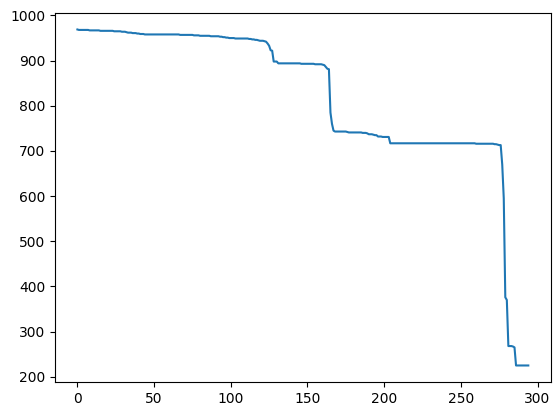

In [65]:
import matplotlib.pyplot as plt
import numpy as np
y = target["DRUG_ID"].value_counts()
x = np.arange(y.shape[0])
plt.plot(x,y)
y

## Questions
- negative IC50? -> normalization?
- Are there information for genes and/or for models?
- Transposed rnaseq for consistent dtypes? First row removed since its only symbol
- How connected? (see DrawIO) or different?
- What is vaf in mutations? variant allele fraction
- Why is gene_id in rna_seq always nan?
- Which features from mutations and genes I listed are irrelevant?

## Problems
	
 duplicate model_id + gene_id
 model_name	model_id	symbol	gene_id	chr_name	chr_start	chr_end	total_copy_number	minor_copy_number	loh	...	seg_mean	gene_mean	num_targets	focal	breakpoints	num_snps	gatk_mean_log2_copy_ratio	comment	source	data_type
0	MEC-1	SIDM00001	ABCB1	SIDG00064	chr7	87503966	87600461	3.0	1.0	False	...	0.599167	0.414125	28.0	False	0.0	1124.0	0.574127	POOR GOF (70.4%)	Sanger	WES
844	MEC-1	SIDM00001	ABCB1	SIDG00064	chr7	87503966	87600461	3.0	1.0	False	...	0.551774	0.692527	

-> pre-filter? highest POF in comment? or take both?